#### This is an application of my Neural Network class using the Minst Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import NeuralNets as NN_
#import NeuralNets_cython as NN
import pytorch_NN as PyNN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

### Load dataset

In [2]:

minst = pd.read_csv("mnist_train.csv").to_numpy()
#minst = pd.read_csv("fashion-mnist_train.csv").to_numpy()
yactual_uncleaned = minst[:,0:1].flatten()
xactual = minst[:,1:]/255
yactual = np.zeros((60000,10))
for i,y in enumerate(yactual_uncleaned):
    yactual_temp = np.zeros(10)
    yactual_temp[y] = 1
    yactual[i] = yactual_temp


### Split into train, validate

In [3]:
data_set  = PyNN.CustomDataset(xactual,yactual)
train,validate = random_split(data_set,[int(.95 * len(data_set)),int(0.05 * len(data_set))])
num_epochs = 30
dataset_size = 60000
batch_size = 1000

## NOTE ##
## The only thing from pytorch I used was the dataloader.
## Everything else was my own work done in Numpy
data_loader_train = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
data_loader_validate = DataLoader(dataset=validate, batch_size=batch_size, shuffle=False)

In [4]:
## NN parameters
input_dim = 784
output_dim = 10
num_hidden_layers = 3
nodes_per_layer = 650
activation_fcn_ = "SiLU"
classifier_ = True

## Training parameters
optimizer_="ADAM"
minibatch_sz = batch_size
lr_ = .0005

## Simulation parameters
train_batch_percent = []
save_validation_history = True
use_tensors_=True
save_freq = 5 #epochs
save_val_freq = 10 #batches

## Temp values
small_number = 1e-15
CEL = 0
save_count = 0

In [5]:
## MY IMPLEMENTATION
tensor = NN_.FullyConnected(input_dim,output_dim,nodes_per_layer,num_hidden_layers,minibatch_sz,activation_fcn=activation_fcn_,optimizer=optimizer_,classifier=classifier_,use_tensors=use_tensors_)   

### MAIN LOOP

In [6]:

for epoch in range(0, num_epochs+1):
    batch_count = 0
    if epoch==num_epochs:
        NN_.save_state(tensor,"epoch"+str(epoch))
        break
    
    if epoch % save_freq == 0:
        NN_.save_state(tensor,"epoch"+str(epoch))
    
    for batch_x_train, batch_y_train in data_loader_train:
        ypred_train = tensor.forward(batch_x_train.numpy()).squeeze().T
        current_percent_correct = NN_.validate_data(ypred_train,batch_y_train.detach().numpy())
        tensor.gradient(ypred_train,batch_y_train.numpy(),batch_x_train.numpy())
        tensor.updateWeights(lr=lr_,alg=tensor.optimizer,clip_gradients = False)
        CEL = np.around(-np.mean(batch_y_train.numpy() * np.log(np.clip(ypred_train, small_number, 1 - small_number))),decimals=4)
        tensor.loss_history.append(CEL)
        print("[epoch: "+str(epoch)+" Batch: "+str(batch_count)+" ]  -----> Loss: "+str(CEL)+ "; Batch percent correct: "+str(current_percent_correct))
    
        if save_validation_history and save_count % save_val_freq==0:
            mean_percent_valid = 0
            mean_percent_train = 0
            for batch_x_train_, batch_y_train_ in data_loader_train:
                ypred_train_ = tensor.forward(batch_x_train_.numpy()).squeeze().T
                mean_percent_train += NN_.validate_data(ypred_train_,batch_y_train_.detach().numpy())/len(data_loader_train)
            for batch_x_test, batch_y_test in data_loader_validate:
                ypred_validate = tensor.forward(batch_x_test.numpy()).squeeze().T
                mean_percent_valid += NN_.validate_data(ypred_validate,batch_y_test.detach().numpy())/len(data_loader_validate)
            tensor.test_validation.append(mean_percent_valid)
            tensor.train_validation.append(mean_percent_train)
            print("\n TEST VALIDATION %---->  ",mean_percent_valid)
            print(" TRAIN VALIDATION %---->  ",mean_percent_train)
            print("")

        batch_count+=1
        save_count+=1
    
print("------------------  DONE --------------------")   

[epoch: 0 Batch: 0 ]  -----> Loss: 0.23; Batch percent correct: 11.600000000000001

 TEST VALIDATION %---->   11.333333333333334
 TRAIN VALIDATION %---->   12.222807017543857

[epoch: 0 Batch: 1 ]  -----> Loss: 0.2297; Batch percent correct: 13.100000000000001
[epoch: 0 Batch: 2 ]  -----> Loss: 0.2286; Batch percent correct: 15.6
[epoch: 0 Batch: 3 ]  -----> Loss: 0.2281; Batch percent correct: 16.6
[epoch: 0 Batch: 4 ]  -----> Loss: 0.2277; Batch percent correct: 16.3
[epoch: 0 Batch: 5 ]  -----> Loss: 0.2257; Batch percent correct: 21.5
[epoch: 0 Batch: 6 ]  -----> Loss: 0.2247; Batch percent correct: 24.7
[epoch: 0 Batch: 7 ]  -----> Loss: 0.2234; Batch percent correct: 26.0
[epoch: 0 Batch: 8 ]  -----> Loss: 0.2223; Batch percent correct: 27.700000000000003
[epoch: 0 Batch: 9 ]  -----> Loss: 0.2206; Batch percent correct: 28.199999999999996
[epoch: 0 Batch: 10 ]  -----> Loss: 0.2188; Batch percent correct: 31.5

 TEST VALIDATION %---->   35.53333333333334
 TRAIN VALIDATION %---->  

### Plot accuracy
- I used number of (correct predictions)/(batch size)

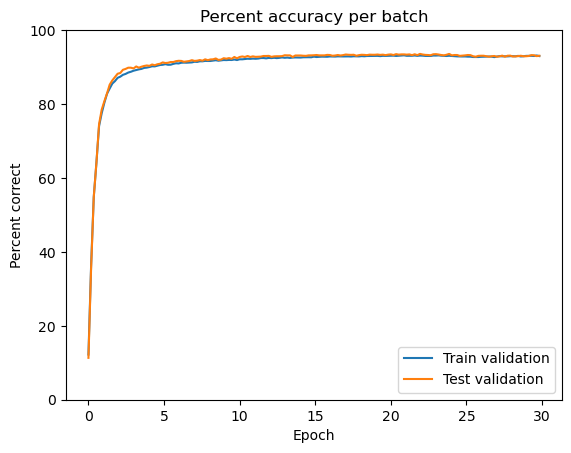

In [7]:
plt.title("Percent accuracy per batch")
plt.xlabel("Epoch")
plt.ylabel("Percent correct")
plt.ylim([0,100])
x = np.arange(len(tensor.train_validation))*save_val_freq/(len(train)/minibatch_sz)
plt.plot(x,tensor.train_validation)
plt.plot(x,tensor.test_validation)
plt.legend(["Train validation", "Test validation"])

### Plot loss

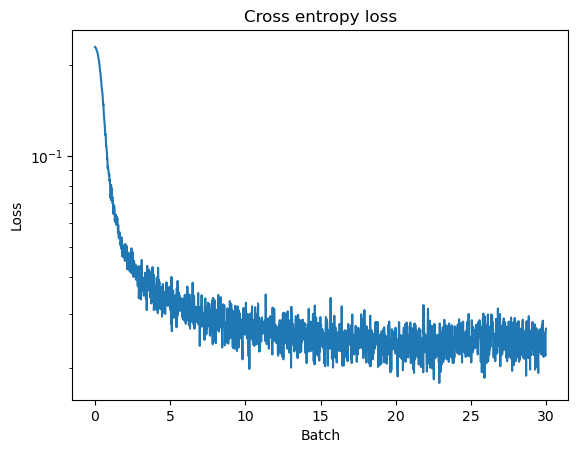

In [8]:
plt.title("Cross entropy loss")
plt.ylabel("Loss")
plt.xlabel("Batch")
x = np.arange(len(tensor.loss_history))/(len(train)/minibatch_sz)
plt.semilogy(x,np.array(tensor.loss_history))

### Quick sanity check...

NN predicted number:  2


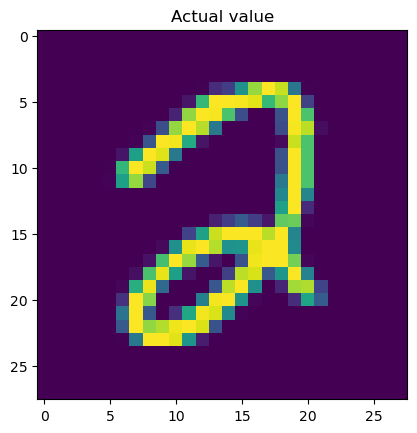

In [9]:

x = 290
vec = (batch_x_train[x].numpy()*255).astype(int)
print("NN predicted number: ", np.argmax(ypred_train[x]))
matrix = vec.reshape(28,28)
plt.imshow(matrix)
plt.title("Actual value")
plt.show()

### Load test data
- TODO: This data cleaning should be in the other file

In [16]:

minst_test = pd.read_csv("mnist_test.csv").to_numpy()
test_NN = tensor

## This particular test did best at around epoch 20
test_NN = NN_.load_state(f"checkpoints/epoch{20}.pkl")
yactual_uncleaned = minst_test[:,0:1].flatten()
xactual_test = minst_test[:,1:]/255
yactual_test = np.zeros((len(minst_test),10))
for i,y in enumerate(yactual_uncleaned):
    yactual_temp = np.zeros(10)
    yactual_temp[y] = 1
    yactual[i] = yactual_temp

### Test with test dataset

In [17]:
y_pred = np.array([np.argmax(test_NN.forward_sample(xactual_test[i,:],0)) for i in range(len(minst_test))]).squeeze()#range(len(xactual[:,0]))]

### Create and display confusion matrix

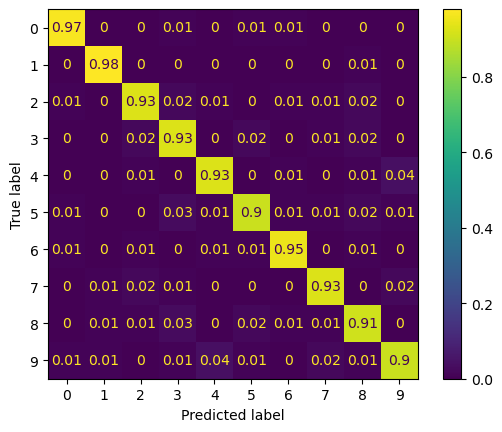

In [18]:
confusion_matrix_ = np.around(confusion_matrix(np.argmax(yactual[0:len(y_pred):,:],axis=1), y_pred,normalize='true'),2)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_)
disp.plot()

In [19]:
confusion_matrix_ = np.around(confusion_matrix(np.argmax(yactual[0:len(y_pred):,:],axis=1), y_pred),2)
total_percent_correct = np.sum(np.diag(confusion_matrix_))/np.sum(confusion_matrix_.flatten())
print("Percent correct classifications over entire test set: ----> ",total_percent_correct,"%")

Percent correct classifications over entire test set: ---->  0.9337 %
